# But prise en main des objets créés par mes collègues et lancement d'un entrapînement à partir de la BDTOPO ou du RIL en tant que LAbel ??

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
! pip install rasterio  -q -q -q
! pip install geopandas -q -q -q
! pip install matplotlib -q -q -q

In [ ]:
import sys
sys.path.append('../src')
from satellite_image import SatelliteImage
from utils import *


In [ ]:
import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
os.environ["AWS_ACCESS_KEY_ID"]="ZQUP3MQ45V25LYPYH1MC"
os.environ["AWS_SECRET_ACCESS_KEY"]="jFE8Cbio6Dt3dZvV5qbd9j3k9bGL6tDESjnxu4xm"
os.environ["AWS_S3_ENDPOINT"]='minio.lab.sspcloud.fr'
os.environ["AWS_SESSION_TOKEN"]="eyJhbGciOiJIUzUxMiIsInR5cCI6IkpXVCJ9.eyJhY2Nlc3NLZXkiOiJaUVVQM01RNDVWMjVMWVBZSDFNQyIsImFsbG93ZWQtb3JpZ2lucyI6WyIqIl0sImF1ZCI6WyJtaW5pby1kYXRhbm9kZSIsIm9ueXhpYSIsImFjY291bnQiXSwiYXV0aF90aW1lIjoxNjc4MTAxMjU5LCJhenAiOiJvbnl4aWEiLCJlbWFpbCI6ImNsZW1lbnQuZ3VpbGxvQGluc2VlLmZyIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsImV4cCI6MTY3ODU0MjI1OCwiZmFtaWx5X25hbWUiOiJHdWlsbG8iLCJnaXZlbl9uYW1lIjoiQ2zDqW1lbnQiLCJncm91cHMiOlsiY2hhbGxlbmdlZGF0YS1lbnMiLCJmdW5hdGhvbiIsInNsdW1zLWRldGVjdGlvbiJdLCJpYXQiOjE2NzgxMDEyNjAsImlzcyI6Imh0dHBzOi8vYXV0aC5sYWIuc3NwY2xvdWQuZnIvYXV0aC9yZWFsbXMvc3NwY2xvdWQiLCJqdGkiOiIwZmVkMDQ2My0zMWQ3LTRlMDMtYjJjZS04MDhkNWEyOTI4ZjkiLCJsb2NhbGUiOiJlbiIsIm5hbWUiOiJDbMOpbWVudCBHdWlsbG8iLCJub25jZSI6ImY3M2VhNGU1LTk4MzEtNGM2Yy04ZDhjLTU5MDMwYWE1ZTU3NiIsInBvbGljeSI6InN0c29ubHkiLCJwcmVmZXJyZWRfdXNlcm5hbWUiOiJjZ3VpbGxvIiwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbIm9mZmxpbmVfYWNjZXNzIiwidW1hX2F1dGhvcml6YXRpb24iXX0sInJlc291cmNlX2FjY2VzcyI6eyJhY2NvdW50Ijp7InJvbGVzIjpbIm1hbmFnZS1hY2NvdW50IiwibWFuYWdlLWFjY291bnQtbGlua3MiLCJ2aWV3LXByb2ZpbGUiXX19LCJzY29wZSI6Im9wZW5pZCBwcm9maWxlIGdyb3VwcyBlbWFpbCIsInNlc3Npb25fc3RhdGUiOiJjZGNhODY0Yy1hYzIyLTQzZTAtODNiYi04YjIyNTE0YTNmODQiLCJzaWQiOiJjZGNhODY0Yy1hYzIyLTQzZTAtODNiYi04YjIyNTE0YTNmODQiLCJzdWIiOiIzYjA2ZWZhNC01OWZlLTQzYzgtYTAyYi1hOTRkOWI0YjU0NGUiLCJ0eXAiOiJCZWFyZXIifQ.Pwj578LyGhEZ4tN4nf_4UqOle5b2TouT2_YTYY-cfpVtoOVBOZW6Ndg66igsw37Gt6LE8Q_p7rugF4HrAQWnvA"

In [ ]:
fs = get_file_system() # bien définir les variables d'environnement en amont !

In [ ]:
fs.ls('projet-slums-detection/Donnees/RIL/')

In [ ]:
environment = get_environment()

root_path = get_root_path()
bucket = environment["bucket"]
path_s3_cayenne_data = environment["sources"]["PLEIADES"]
path_local_cayenne_data = os.path.join(root_path, environment["local-path"]["PLEIADES"])
bucket = environment["bucket"]

path_s3_pleiades_data = environment["sources"]["PLEIADES"]
path_s3_bdtopo_data = environment["sources"]["BDTOPO"][2022]["guyane"]
path_local_pleiades_data = environment["local-path"]["PLEIADES"]
path_local_bdtopo_data = environment["local-path"]["BDTOPO"][2022]["guyane"]


In [ ]:
# DL PLEIADE
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data}",
        lpath=f"../{path_local_pleiades_data}",
        recursive=True)


In [ ]:
# DL BDTOPO
fs.download(
        rpath=f"{bucket}/{path_s3_bdtopo_data}",
        lpath=f"../{path_local_bdtopo_data}",
        recursive=True)


## Chargement données pleiades

In [ ]:
filename = 'Cayenne_200722/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0353_0545_U22N_16Bits.jp2'
date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d')
date

In [ ]:
image = SatelliteImage.from_raster(
        filename,
        date = date, 
        n_bands = 4,
        dep = "973"
    )
image.normalize()

In [ ]:
list_images = image.split(250)
list_images[0].array
len(list_images)

In [ ]:
image.plot([0,1,2])
image.plot([3,1,2])

## Représenter la liste des images sous forme de grille (ajouter une fonction)

In [ ]:
SatelliteImage.plot_list_satellite_images(list_images,bands_indices = [3,1,2])

In [ ]:
64*256 # nb de patchs utilisables pour entrainer un modèle, why not ?

In [ ]:
#image.plot([0,1,2])
image.normalized 

## Récupération des labellisations

In [ ]:
from labeler import RILLabeler

Définition d'une instance de labeller (on donneune datez et un département et on va chercher les labels associés RIL à côté)

In [ ]:
labeler = RILLabeler(date, dep = "973", buffer_size= 20)

Le labeller est chargé une bonne fois pour toute donc pas de problème

In [ ]:
mask = labeler.create_segmentation_label(image) # va chercher les données et rasterise les bounding box

In [ ]:
image.normalize
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(np.transpose(image.array_to_plot, (1, 2, 0))[:,:,:3])
ax.imshow(mask, alpha=0.3) # magnifique ! Faire une fonction  de représentation  ? # faire du découpage ? ou une fonction de sélection aléatoire d'une tuile ?

# Plus qu'à faire la même chose sur le mont baduel :)

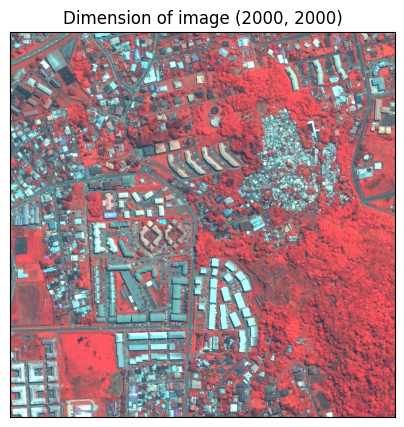

In [31]:
filename = 'Cayenne_200722/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0354_0545_U22N_16Bits.jp2'
date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d')
date

image = SatelliteImage.from_raster(
        filename,
        date = date, 
        n_bands = 4,
        dep = "973"
    )

image.plot([3,1,2])

In [ ]:
SatelliteImage.plot_list_satellite_images(image.split(250),[0,1,2])

## Ril

In [ ]:

labeler = RILLabeler(date, dep = "973", buffer_size= 20)
mask = labeler.create_segmentation_label(image)
#image.normalize()
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(np.transpose(image.array_to_plot, (1, 2, 0))[:,:,:3])
ax.imshow(mask, alpha=0.3) # magnifique ! Faire une fonction  de représentation  ? # faire du découpage ? ou une fonction de sélection aléatoire d'une tuile ?

## BD TOPO

In [21]:
from labeler import BDTOPOLabeler

In [22]:
labeler_bdtopo = BDTOPOLabeler(date, dep = "973") # charghement lenbt nécessite d'avoir downloader la BDTOPO avant. fluidifier ça ?

In [32]:
mask = labeler_bdtopo.create_segmentation_label(image)

In [ ]:
if image.normalize == False:
    image.normalize
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(np.transpose(image.array_to_plot, (1, 2, 0))[:,:,:3])
ax.imshow(mask, alpha=0.3) # magnifique ! Faire une fonction  de représentation  ? # faire du découpage ? ou une fonction de sélection aléatoire d'une tuile ?

Le chargement lent milite pour repréparer le jeu de données en amont une fois qu'on est fixé sur la taille avant de créer les Dataset etc..

Le moint Baduel a bien été cartographié !

## Mélange images Labels !

In [56]:
from labeled_satellite_image import SegmentationLabeledSatelliteImage

Ok ici on a des objets qui fonct cohabiter image et son label (image + segmentation mask (RIL ou BDTOPO))
On pourra faire la même chose avec la detection ou l'optique patchs etc..(il nous faut des fonctions de représentation à chaque fois) 

- de superposition image et label
- et de mise cote à cote
- possibnilité de revenir à la géométrie à chaque fois


In [60]:
#image.normalize()
image_labellisee = SegmentationLabeledSatelliteImage(image,label = mask, labeling_date = date, source = "BDTOPO")


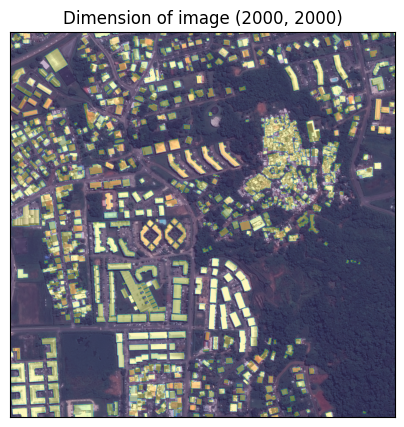

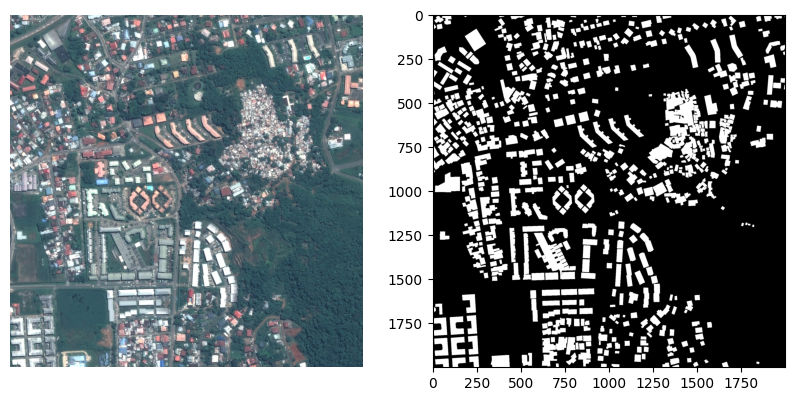

In [61]:
# 1) plot image et masque superposés
image_labellisee.plot([0,1,2])

# 2) plot image et masque associés côte à côte
image_labellisee.plot_label_next_to_image([0,1,2])


## fonction split

In [63]:
liste_image_labelisee = image_labellisee.split(250)
liste_image_labelisee

## Plot liste image labellisée 

In [ ]:
SegmentationLabeledSatelliteImage.plot_list_segmentation_labeled_satellite_image(liste_image_labelisee,[0,1,2])

## Plot les masques de détection

## TO DO 
- Vérifier si ma fonction plot list images s'adapte à la,liste d'image globale
- création d'une classe Dataset particulière 
- comment créer un DataSet à partir des images originales ? utiliser des fonctions split successives, stacker etc..mais on ne va pas tout garder en mémoire.. création de nouveaux fichiers image ? ou bien technique 2 splitter et sélectionner aléatoirement une ou plusieur zones dans l'image ? -> voir avec les gars
- Faire une fonction create bounding box pour yolo etc.. c'est l'objet de create detection label , faire une fonction de représentation ?
- access Vault ? -W> dans projet slums detection bidonvilles
- Faire un notebook de prise en main pour les stagiaires -> en cours
- faire une fonction plot label on images (superposition)
- faire une fonction plot label next to image -> done
- faire une fonction plot liste image -> done
- fair eune fonction plot list of label images
- faire une fonction qui a partir d'un masque de segmentation donné sors les polygones associés (revenir sur rasterio ?)
- Pour les datasets, les classes faire une classe généralsite Dataset Segmentation et détection et patchs
- et faire plusieurs types de dataset segmentation dépendant du jeu de données et la stratégie de chargement
- ppour les modèles il faudra faire une surclasse modeles segment ation/detection et créer des modèlmes ad hoc etc.. De telle sorte qu'un modèle de segmentation puisse s'appliquer sans douleur sur un dataset de segmentation